In [1]:
from typing import Tuple, List, Dict, Any

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from rdkit.Chem import QED
import selfies as sf

import numpy as np
import math
from math import ceil, log2, comb
import re
import pandas as pd
import optax
import csv
import json
import flax.linen as nn
import itertools
from functools import partial
import time

import pennylane as qml
from pennylane import qchem
from pennylane.templates import StronglyEntanglingLayers

import jax
import jax.random as random
from jax import random
import jax.numpy as jnp
import jax.nn as jnn
from jax.nn.initializers import normal

import haiku as hk

# Data Preparation

In [83]:
# Load metadata from JSON
N_MOLECS = 5000
META_DATA_PATH = f"../data/metadata_selfies_{N_MOLECS}.json"

with open(META_DATA_PATH, "r") as f:
    metadata = json.load(f)

VOCABULARY_SIZE = metadata['vocabulary_size']
BITS_PER_TOKEN = metadata['bits_per_token']
MAX_LEN = metadata['max_sequence_length']
ALPHABET = metadata['alphabet']
min_logp = metadata['min_logP']
max_logp = metadata['max_logP']
min_qed = metadata['min_qed']
max_qed = metadata['max_qed']
min_mw = metadata['min_mw']
max_mw = metadata['max_mw']

print("Vocabulary Size:", VOCABULARY_SIZE)
print("Bits per Token:", BITS_PER_TOKEN)
print("Max Sequence Length:", MAX_LEN)
print("Alphabet:", ALPHABET)


Vocabulary Size: 32
Bits per Token: 5
Max Sequence Length: 31
Alphabet: ['<SOS>', '[#Branch1]', '[#Branch2]', '[#C]', '[#N]', '[=Branch1]', '[=Branch2]', '[=C]', '[=N]', '[=O]', '[=PH1]', '[=P]', '[=Ring1]', '[=S]', '[Br]', '[Branch1]', '[Branch2]', '[C]', '[Cl]', '[F]', '[H]', '[I]', '[NH1]', '[N]', '[O]', '[PH1]', '[P]', '[Ring1]', '[Ring2]', '[S]', '<EOS>', '<PAD>']


In [ ]:
# --- Auxiliary functions ---

def normalize(value, min_val, max_val, target_max=np.pi):
    ''' Normalize a value to a range [0, [0, pi] to later encode them as rotation angles'''
    norm = (value - min_val) / (max_val - min_val) * target_max
    return float(f"{norm:.3f}")

def token_to_index(token):
    ''' Map a SELFIES token to its corresponding index in the ALPHABET'''
    if token in ALPHABET:
        return ALPHABET.index(token)
    else:
        return None

def bits_to_index(bits):
    powers = 2 ** jnp.arange(len(bits) - 1, -1, -1)
    return jnp.dot(bits, powers).astype(jnp.int32)

In [84]:
PAD_index = token_to_index("<PAD>")
SOS_index = token_to_index("<SOS>")
EOS_index = token_to_index("<EOS>")

In [85]:
def load_dataset_bits_batch(csv_path, n_bits=BITS_PER_TOKEN):
    """
    Read the dataset from a CSV file and convert it into bit representations for quantum processing.
    Args:
        csv_path (str): Path to the CSV file containing the dataset.
        n_bits (int): Number of bits used to represent each token.
    Returns:
        Tuple containing:
            - X_bits (jnp.ndarray): Input bit representations of shape (N_Molecules, MAX_LEN-1, n_bits).
            - Props (jnp.ndarray): Molecular properties of shape (N_Molecules, 3).
            - Y_indices (jnp.ndarray): Target token indices of shape (N_Molecules, MAX_LEN-1).
    """
    
    df = pd.read_csv(csv_path, dtype=str)
    print("Dataset loaded with shape:", df.shape)
    
    # Properties: logP, qed, mw
    # Shape: (N_Moleculas, 3)
    # Types: float
    props = df.iloc[:, :3].astype(float).values
    
    # Tokens
    # Shape: (N_Moleculas, MAX_LEN)
    # Types: string (e.g., "00101")
    token_cols = df.iloc[:, 3:].values
    
    # Auxiliary function to convert a string of '0's and '1's to a list
    def str_to_bit_list(s):
        return [int(c) for c in s]

    # 3D array to hold all bits
    all_bits = np.array([
        [str_to_bit_list(token) for token in row] 
        for row in token_cols
    ])
    
    # X_bits: Input for the model.
    # Take all tokens except the last one.
    X_bits = all_bits[:, :-1, :] 
    
    # Y_ind: Target indices for the model.
    # Take all tokens except the first one.
    # Convert from bit strings to integer indices (for loss calculation).
    Y_indices = np.array([[int(t, 2) for t in row[1:]] for row in token_cols])

    return jnp.array(X_bits), jnp.array(props), jnp.array(Y_indices)


In [86]:
MOLECS_DATA_PATH = f"../data/structured_data_selfies_{N_MOLECS}.csv"
X_bits, Props, Y_ind = load_dataset_bits_batch(MOLECS_DATA_PATH)

print("Loaded data:")
print("X_bits shape:", X_bits.shape) # (N, L, 5)
print("Props shape:", Props.shape)   # (N, 3)
print("Y_ind shape:", Y_ind.shape)   # (N, L)

Dataset loaded with shape: (4777, 34)
Loaded data:
X_bits shape: (4777, 30, 5)
Props shape: (4777, 3)
Y_ind shape: (4777, 30)


## Quantum Circuit

### Attention Computation

In [7]:
# Quantum Attention mechanism using SWAP test
n_past = 5
attn_dev = qml.device("default.qubit", wires=(BITS_PER_TOKEN+1)*n_past)

@qml.qnode(attn_dev, interface="jax")
def quantum_attention_qnode(Q_vec, K_vecs):
    """
    Q_vec: projected query vector of current token
    K_vecs: list of projected key vectors for past tokens
    Returns: attention scores ⟨q_i | k_j⟩ for each j
    """
    n_tokens = len(K_vecs)
    q_wires = list(range(BITS_PER_TOKEN))

    # Encode Q and all K in parallel (different wire registers)
    def encode_token(angles, wires):
        # Use AngleEmbedding for compactness, then entangle
        qml.templates.AngleEmbedding(angles, wires=wires, rotation="Y")
        for i in range(len(wires)-1):
            qml.CNOT(wires=[wires[i], wires[i+1]])

    # Encode Q
    encode_token(Q_vec, wires=q_wires)

    # Encode K_j
    # Collect expectation values (one per K_j)
    measurements = []
    for j, K_j in enumerate(K_vecs):
        start = (BITS_PER_TOKEN+1) + j*(BITS_PER_TOKEN+1)
        k_wires = list(range(start, start+BITS_PER_TOKEN))
        encode_token(K_j, k_wires)

        # SWAP test
        ancilla = start + BITS_PER_TOKEN
        qml.Hadamard(wires=ancilla)
        for qw, kw in zip(q_wires, k_wires):
            qml.CSWAP(wires=[ancilla, qw, kw])
        qml.Hadamard(wires=ancilla)

        measurements.append(qml.expval(qml.PauliZ(ancilla)))

    # **Return as tuple** so PennyLane converts to JAX array
    return tuple(measurements)


def quantum_attention(Q_vec, K_vecs, V_vecs):
    # Make non-traced (concrete) copies for the QNode
    Q_safe = jax.lax.stop_gradient(Q_vec)
    K_safe = [jax.lax.stop_gradient(k) for k in K_vecs]

    raw_expvals = quantum_attention_qnode(Q_safe, K_safe)
    raw_expvals = jnp.asarray(raw_expvals)
    # Convert from expectation values (in [-1,1]) to probabilities [0,1]
    overlaps = (1.0 - raw_expvals) / 2.0
    return overlaps


def classical_attention(Q_vec, K_vecs, V_vecs, mask, scale=True):
    """
    Calculates classical dot-product attention with padding mask.

    Args:
        Q_vec: Query vector, shape (proj_dim,)
        K_vecs: Key matrix, shape (n_past, proj_dim)
        V_vecs: Value matrix, shape (n_past, proj_dim)
        mask: Padding mask, shape (n_past,). 
              Contains 0.0 for valid tokens and -jnp.inf for padding.
        scale: Whether to scale scores by sqrt(proj_dim).
        
    Returns:
        Output context vector, shape (proj_dim,)
    """
    if len(K_vecs) == 0:
        return V_vecs[0] if len(V_vecs) > 0 else jnp.zeros_like(Q_vec)

    K_mat = jnp.stack(K_vecs)  # shape (n_past, proj_dim)
    V_mat = jnp.stack(V_vecs)  # shape (n_past, proj_dim)
    # dot-product softmax (fully differentiable)
    scores = jnp.dot(K_mat, Q_vec)  # shape (n_past,)
    if scale:
        scores = scores / jnp.sqrt(Q_vec.shape[0])
    # Causal mask: only past tokens (K_vecs are already past tokens)
    # Adding -inf makes the softmax probability of pad tokens zero.
    scores = scores + mask
    weights = jax.nn.softmax(scores)

    # Weighted sum over classical V
    output = jnp.dot(weights, V_mat)
    return output

### Quantum Parametrized Circuit 

In [ ]:
def zstring_combos(wires):
    """
    Return an ordered list of wire-tuples for all Z-strings up to order H_LOCAL.
    Order: all 1-local, then all 2-local, ..., up to H_LOCAL.
    """
    L = []
    for k in range(1, H_LOCAL + 1):
        L.extend(itertools.combinations(wires, k))
    return [tuple(c) for c in L]

def num_zstrings(n_wires):
    """
    Count how many Z-strings up to order H_LOCAL.
    """
    return sum(comb(n_wires, k) for k in range(1, H_LOCAL + 1))

In [8]:
# Circuit parameters ----------------------------------------------------------------------
N_LAYERS = 6  # number of variational layers
H_LOCAL = 2 # h_local sets the maximum number of qubits that can interact in each Z term
# ------------------------------------------------------------------------------------------


# Name the qubit wires explicitly
n_prop_qubits = 3  # number of qubits needed to encode properties (logP, QED, MW)
n_ancillas = 3  # number of ancilla qubits that represent the environment
n_total_qubits = n_prop_qubits + BITS_PER_TOKEN + n_ancillas

prop_wires = [f"prop_{i}" for i in range(n_prop_qubits)]
token_wires = [f"token_{i}" for i in range(BITS_PER_TOKEN)]
ancilla_wires = [f"ancilla_{i}" for i in range(n_ancillas)]
all_wires = prop_wires + token_wires + ancilla_wires

dev = qml.device("default.qubit", wires=all_wires)
#dev = qml.device("lightning.qubit", wires=all_wires)


def molecular_property_encoder(props):
    """Encode continuous props on property qubits via RY rotations"""
    for wire, val in zip(prop_wires, props):
        qml.RY(val, wires=wire)


def token_encoder(token_bits):
    """Soft basis encoding using RX rotation"""
    for i in range(BITS_PER_TOKEN):
        angle = token_bits[i] * jnp.pi 
        qml.RX(angle, wires=token_wires[i])


def operator_layer(theta_params, theta_prop, wires):
    """
    Variational layer where:
      - theta_params[...] are rotations for token + ancilla qubits
      - theta_prop encodes property→token entanglement
    """
    token_ancilla_ws = token_wires + ancilla_wires

    # Property → token entanglement 
    for p, prop_wire in enumerate(prop_wires):
        for t, t_a_wire in enumerate(token_ancilla_ws):
            qml.CRX(theta_prop[p, t, 0], wires=[prop_wire, t_a_wire])
            qml.CRY(theta_prop[p, t, 1], wires=[prop_wire, t_a_wire])

    # Strongly entangling layers on token + ancilla qubits
    qml.StronglyEntanglingLayers(
        weights=theta_params[None,:,:],  # shape: (n_token_ancilla, 3)
        wires=token_ancilla_ws
    )

def Sigma_layer_vec(gamma_vec, token_ancilla_ws, time=1.0, combos=None):
    """
    Diagonal multi-Z unitary Σ = exp(i * sum_s gamma_s * Z^{⊗|s|} * t)
    using a flat parameter vector 'gamma_vec' aligned with 'combos'.
    """
    if combos is None:
        combos = zstring_combos(token_ancilla_ws)

    # Safety: ensure the vector length matches the number of combos
    assert gamma_vec.shape[0] == len(combos), \
        f"gamma_vec has length {gamma_vec.shape[0]} but expected {len(combos)}"

    # MultiRZ(phi) = exp(-i * phi/2 * Z^{⊗k}); choose phi = -2 * gamma * time
    for gamma, combo in zip(gamma_vec, combos):
        qml.MultiRZ(-2.0 * gamma * time, wires=list(combo))


@qml.qnode(dev, interface="jax", diff_method="backprop")
def autoregressive_model(token_bits, props, theta_params, theta_prop, sigma_params, attention_context):
    """
    QNode for the autoregressive model.
    Args:
        token_bits: Bit representation of input tokens (shape: BITS_PER_TOKEN,)
        props: Molecular properties (shape: 3,)
        theta_params: Variational parameters for operator layers (shape: N_LAYERS, n_token_ancilla, 3)
        theta_prop: Property entanglement parameters (shape: N_LAYERS, n_prop_qubits, n_token_ancilla, 2)
        sigma_params: Parameters for Sigma layers (shape: N_LAYERS, num_zstrings)
        attention_context: Token attention output encoding (shape: BITS_PER_TOKEN,)
    Returns:
        Probabilities over token qubits and expectation values of property qubits.
    """
    molecular_property_encoder(props)      # Encode MW, logP, QED
    token_encoder(token_bits)              # Basis-encode token bits

    # Encode attention context on token qubits
    for i, val in enumerate(attention_context):
        qml.RY(val, wires=token_wires[i])

    token_ancilla_ws = token_wires + ancilla_wires
    combos = zstring_combos(token_ancilla_ws)

    for l in range(N_LAYERS):
        # Forward V(θ)
        operator_layer(theta_params[l], theta_prop[l], wires=all_wires)

        # Diagonal Σ(γ,t): vector API
        Sigma_layer_vec(sigma_params[l], token_ancilla_ws, time=1.0, combos=combos)

    return qml.probs(wires=token_wires), [qml.expval(qml.PauliZ(w)) for w in prop_wires]


### Loss and Accuracy

In [9]:
def total_loss_fn(pred_probs, prop_expvals, target_indices, props, PAD_index, alpha=0.5, epsilon=0.1):
    """
    Computes normalized loss for a Batch of sequences.
    Handles prop_expvals whether it comes as a list or an array.
    Args:
        pred_probs: (Batch, Length, Vocab) - Predicted token probabilities
        prop_expvals: (Batch, Length, P) or List of (Batch, Length) arrays - Predicted property expectation values
        target_indices: (Batch, Length) - Target token indices
        props: (Batch, P) - Target molecular properties
        PAD_index: Index used for padding tokens
        alpha: Weighting factor for property loss
        epsilon: Label smoothing factor for cross-entropy loss
    Returns:
        Normalized combined loss (scalar)
    """
    # Handle List vs Array Input
    if isinstance(prop_expvals, list) or isinstance(prop_expvals, tuple):
        # If it's a list of (B, L) arrays, stack them to get (B, L, P)
        prop_expvals = jnp.stack(prop_expvals, axis=-1)
        
    # 1. Get dimensions
    # Now prop_expvals is guaranteed to be (B, L, P)
    vocab_size = pred_probs.shape[-1] 
    B, L, P = prop_expvals.shape 
    
    # 2. Flatten dimensions for easier processing (B*L, Vocab)
    flat_probs = pred_probs.reshape(-1, vocab_size)
    flat_targets = target_indices.reshape(-1)
    
    # 3. Cross-Entropy with Label Smoothing
    target_one_hot = jax.nn.one_hot(flat_targets, vocab_size)
    
    smooth_target = jnp.full_like(flat_probs, epsilon / (vocab_size - 1))
    smooth_target = jnp.where(target_one_hot == 1, 1.0 - epsilon, smooth_target)
    
    loss_per_token = -jnp.sum(smooth_target * jnp.log(flat_probs + 1e-10), axis=-1)

    # 4. Property Loss (MSE)
    # Target props: (B, P) -> Broadcast to (B, L, P)
    target_props = jnp.cos(props)[:, None, :] 
    target_props = jnp.broadcast_to(target_props, (B, L, P))
    
    # Flatten both to (B*L, P) for calculation
    flat_target_props = target_props.reshape(-1, P)
    flat_expvals = prop_expvals.reshape(-1, P)
    
    # Mean MSE across the properties (axis=-1)
    prop_loss_per_token = jnp.mean((flat_expvals - flat_target_props) ** 2, axis=-1)

    # 5. Masking (Ignore PAD tokens)
    mask = (flat_targets != PAD_index).astype(jnp.float32)
    
    # Average only over REAL tokens
    num_real_tokens = jnp.sum(mask) + 1e-9
    mean_ce = jnp.sum(loss_per_token * mask) / num_real_tokens
    mean_prop = jnp.sum(prop_loss_per_token * mask) / num_real_tokens

    # 6. Combine & Normalize
    combined_loss = mean_ce + alpha * mean_prop
    
    max_loss_scale = jnp.log(vocab_size) + alpha * 4.0
    
    return combined_loss / max_loss_scale

    
def compute_accuracy_masked(pred_probs, target_indices):
    """
    Calculates accuracy over non-PAD tokens.
    Args:
        pred_probs: (Batch, Length, Vocab) - Predicted token probabilities
        target_indices: (Batch, Length) - Target token indices
    Returns:
        Normalized accuracy (scalar)
    """
    # Get the predicted token indices (highest probability)
    predicted_indices = jnp.argmax(pred_probs, axis=-1)
    
    # Compare predictions to targets
    correct_predictions = (predicted_indices == target_indices)
    
    # Make to ignore PAD tokens
    mask = (target_indices != PAD_index)
    
    # Sum correct predictions over non-PAD tokens
    numerator = jnp.sum(correct_predictions * mask)
    
    # Divide by number of non-PAD tokens (epsilon to avoid div by zero)
    denominator = jnp.sum(mask) + 1e-9
    
    return numerator / denominator


## Prediction

In [11]:
# Token embedding parameters
key = jax.random.PRNGKey(42)
EMBEDDING_SIZE = BITS_PER_TOKEN + n_ancillas      # size of embeddings
key, k_emb = jax.random.split(key)
embedding_table = jax.random.normal(k_emb, (VOCABULARY_SIZE, EMBEDDING_SIZE)) * 0.1

# Projection matrices for attention
key = jax.random.PRNGKey(42)
proj_dim = BITS_PER_TOKEN  # number of qubits for quantum attention
key, k_WQ, k_WK, k_WV = jax.random.split(key, 4)
W_Q = jax.random.normal(k_WQ, (EMBEDDING_SIZE, proj_dim)) * 0.1
W_K = jax.random.normal(k_WK, (EMBEDDING_SIZE, proj_dim)) * 0.1
W_V = jax.random.normal(k_WV, (EMBEDDING_SIZE, proj_dim)) * 0.1

# Effective qubit counts in variational layers
n_token_ancilla = BITS_PER_TOKEN + n_ancillas

# Initialize theta and sigma params
key = jax.random.PRNGKey(42)
key, k_theta, k_theta_prop, k_sigma = jax.random.split(key, 4)

# Precompute Z-string combos once
token_ancilla_ws = token_wires + ancilla_wires
combos = zstring_combos(token_ancilla_ws)
n_strings = len(combos)

# Combine all trainable parameters into a single dictionary
combined_params = {
    'theta': jax.random.normal(k_theta, (N_LAYERS, n_token_ancilla, 3)) * 0.1,
    'theta_prop': jax.random.normal(k_theta_prop, (N_LAYERS, n_prop_qubits, n_token_ancilla, 4)) * 0.1,
    'sigma': jax.random.normal(k_sigma, (N_LAYERS, n_strings)) * 0.1,
    'embedding_table': embedding_table,
    'W_Q': W_Q,
    'W_K': W_K,
    'W_V': W_V
}

# Training hyperparams
N_EPOCHS = 100
BATCH_SIZE = 8  # Puedes probar 16 o 64 según tu memoria RAM/VRAM
N_SAMPLES = len(X_bits)
STEPS_PER_EPOCH = N_SAMPLES // BATCH_SIZE

# Optimizer with Scheduler: warm up for 10 epochs, then decay
total_steps = N_EPOCHS * STEPS_PER_EPOCH
schedule = optax.warmup_cosine_decay_schedule(
    init_value=0.0,                     # Start from 0 to warm up
    peak_value=1e-3,                    # Peak learning rate
    warmup_steps=10 * STEPS_PER_EPOCH, 
    decay_steps=total_steps,                
    end_value=1e-5                      # End with a very small rate to fine-tune
)

optimizer = optax.adam(learning_rate=schedule)
opt_state = optimizer.init(combined_params)

In [12]:
def single_step_prediction(params, x_token_bits, x_props, context_vec):
    """
    Executes the quantum model for a SINGLE token of a SINGLE molecule.
    Args:
        params: Dictionary of model parameters.
        x_token_bits: Bit representation of the current token (shape: BITS_PER_TOKEN,).
        x_props: Molecular properties (shape: 3,).
        context_vec: Attention context vector (shape: BITS_PER_TOKEN,).
    Returns:
        Tuple of:
            - Probabilities over token qubits (shape: VOCABULARY_SIZE,).
            - Expectation values of property qubits (shape: 3,).
    """
    theta = params['theta']
    theta_prop = params['theta_prop']
    sigma = params['sigma']
    
    # Call Quantum Node
    return autoregressive_model(
        x_token_bits, x_props, theta, theta_prop, sigma, context_vec
    )

# Vectorize from single input to sequence and batch inputs
sequence_predict = jax.vmap(
    single_step_prediction, 
    in_axes=(None, 0, None, 0)
    # params: None      -> same params for all tokens
    # x_token_bits: 0   -> different token bits per token
    # x_props: None     -> same props for all tokens
    # context_vec: 0    -> different context per token
)

batch_predict = jax.vmap(
    sequence_predict, 
    in_axes=(None, 0, 0, 0)
    # params: None      -> same params for all tokens
    # x_token_bits: 0   -> different token bits per token
    # x_props: 0        -> different props per molecule
    # context_vec: 0    -> different context per token
)

In [13]:
def batched_causal_attention(Q, K, V, mask_value=-1e9):
    """
    Computes attention for the whole batch (B, L, E) at once.
    Args:
        Q: Query matrix, shape (B, L, E)
        K: Key matrix, shape (B, L, E)
        V: Value matrix, shape (B, L, E)
        mask_value: Value to use for masked positions (default: -1e9)
    Returns:
        Output matrix after attention, shape (B, L, E)
    """
    d_k = Q.shape[-1] 
    
    # Transpose last two dimensions of K for matrix multiplication
    K_swap = K.swapaxes(-1, -2)  # (B, E, L)

    # Calculate scores: (B, L, E) @ (B, E, L) -> (B, L, L)
    scores = jnp.matmul(Q, K_swap) / jnp.sqrt(d_k)
    
    # Create Mask (Triangular): 1s in the lower triangle, 0s in upper
    L = Q.shape[1]
    causal_mask = jnp.tril(jnp.ones((L, L)))
    
    # Apply mask: Where mask is 0 (future), set score to -infinity
    scores = jnp.where(causal_mask == 1, scores, mask_value)
    
    # Softmax to get weights (probabilities)
    weights = jax.nn.softmax(scores, axis=-1)

    # Multiplies the attention probabilities by the Value matrix V
    output = jnp.matmul(weights, V) # (B, L, E)
    return output

In [15]:
# @partial allows uses JIT compilation while keeping some args static
@partial(jax.jit, static_argnums=(5,))
def training_step_batched(params, opt_state, x_bits_batch, prop_batch, y_target_indices, PAD_index, alpha=0.5):
    """
    Performs a single training step over a batch of data.
    Args:
        params: Model parameters
        opt_state: Optimizer state
        x_bits_batch: Input bits batch (B, L, 5)
        prop_batch: Molecular properties batch (B, 3)
        y_target_indices: Target token indices batch (B, L)
        PAD_index: Index of the PAD token
        alpha: Weight for property loss

    Returns:
        new_params: Updated model parameters
        loss: Computed loss for the batch
        opt_state: Updated optimizer state
        grads: Computed gradients
        acc: Accuracy for the batch
    """
    def loss_fn(params):
        # 1.1. Embedding table lookup
        x_indices = jax.vmap(jax.vmap(bits_to_index))(x_bits_batch)
        input_embeddings = params['embedding_table'][x_indices]
        
        # 1.2. Calculate Positional Encoding (Sinusoidal)
        L = input_embeddings.shape[1]               # Sequence Length

        positions = jnp.arange(L)[None, :]          # Indexes over Length dimension
        dim_indices = jnp.arange(EMBEDDING_SIZE)    # Dimension indices for embedding

        exponent = (dim_indices // 2) * 2 / EMBEDDING_SIZE
        denom = 10000 ** exponent                   # Calculate the frequency denominator

        angles = positions[..., None] / denom       # Calculate angles of PE

        # Apply sine for even indices (2i) and cosine for odd indices (2i+1) 
        pos_enc = jnp.where(dim_indices % 2 == 0, jnp.sin(angles), jnp.cos(angles))
        x_i_pos = input_embeddings + pos_enc

        # 1.3. Compute Q, K, V matrices
        Q = x_i_pos @ params['W_Q']
        K = x_i_pos @ params['W_K']
        V = x_i_pos @ params['W_V']

        # 1.4. Compute (Batched) Attention
        output_context = batched_causal_attention(Q, K, V)

        # 1.5. Quantum Model Prediction
        pred_probs, expval_props = batch_predict(
            params, x_bits_batch, prop_batch, output_context
        )

        # 1.6. Compute Loss
        final_loss = total_loss_fn(
            pred_probs, 
            expval_props, 
            y_target_indices, 
            prop_batch, 
            PAD_index,
            alpha
        )
        
        return final_loss, pred_probs

    # 1. Calculate loss and gradients
    (loss, pred_probs), grads = jax.value_and_grad(loss_fn, has_aux=True)(params)

    # 2. Update parameters
    updates, opt_state = optimizer.update(grads, opt_state, params)
    new_params = optax.apply_updates(params, updates)
    
    # 3. Compute accuracy
    acc = compute_accuracy_masked(pred_probs, y_target_indices)

    return new_params, loss, opt_state, grads, acc

In [16]:
print(f"Starting training with {N_SAMPLES} molecules.")
print(f"Batch Size: {BATCH_SIZE} | Steps per epoch: {STEPS_PER_EPOCH}")

# JAX necesita una clave para barajar (shuffle) los datos si quieres
key = random.PRNGKey(42)

for epoch in range(N_EPOCHS):
    epoch_start_time = time.time() # Track time per epoch
    
    total_loss = 0.0
    total_acc = 0.0
    
    # Opcional: Barajar datos en cada época para mejor generalización
    key, subkey = random.split(key)
    perm = random.permutation(subkey, N_SAMPLES)
    X_shuffled = X_bits[perm]
    P_shuffled = Props[perm]
    Y_shuffled = Y_ind[perm]
    
    # ---- Batched Training Loop ----
    for step in range(0, N_SAMPLES, BATCH_SIZE):
        # 1. Create the Batch (Slicing)
        idx_end = min(step + BATCH_SIZE, N_SAMPLES)
        
        x_batch = X_shuffled[step:idx_end]      # (BATCH_SIZE, 30, 5)
        prop_batch = P_shuffled[step:idx_end]   # (BATCH_SIZE, 3)
        y_batch = Y_shuffled[step:idx_end]      # (BATCH_SIZE, 30)
        
        if len(x_batch) == 0: continue

        # 2. Train all the batch at once
        combined_params, loss, opt_state, grads, acc = training_step_batched(
            combined_params, 
            opt_state, 
            x_batch, 
            prop_batch, 
            y_batch, 
            PAD_index
        )
        
        # 3. Accumulate metrics
        batch_n = len(x_batch)
        total_loss += loss * batch_n
        total_acc += acc * batch_n
        grad_norm = optax.global_norm(grads)

    # Average metrics over epoch
    avg_loss = total_loss / N_SAMPLES
    avg_acc = total_acc / N_SAMPLES
    epoch_time = time.time() - epoch_start_time
    
    print(f"Epoch {epoch+1:03d} | Loss = {avg_loss:.4f} | Accuracy = {avg_acc:.4f} | Time = {epoch_time:.2f}s")

Iniciando entrenamiento con 4777 moléculas.
Batch Size: 8 | Steps por época: 597
Epoch 001 | Loss = 0.5731 | Accuracy = 0.2112 | Time = 494.46s
Epoch 002 | Loss = 0.5026 | Accuracy = 0.3797 | Time = 639.23s
Epoch 003 | Loss = 0.4788 | Accuracy = 0.3860 | Time = 487.65s
Epoch 004 | Loss = 0.4670 | Accuracy = 0.3959 | Time = 444.98s
Epoch 005 | Loss = 0.4602 | Accuracy = 0.3994 | Time = 409.01s
Epoch 006 | Loss = 0.4551 | Accuracy = 0.4027 | Time = 527.28s
Epoch 007 | Loss = 0.4526 | Accuracy = 0.4037 | Time = 474.78s
Epoch 008 | Loss = 0.4504 | Accuracy = 0.4039 | Time = 386.08s
Epoch 009 | Loss = 0.4484 | Accuracy = 0.4052 | Time = 360.74s
Epoch 010 | Loss = 0.4467 | Accuracy = 0.4056 | Time = 405.23s
Epoch 011 | Loss = 0.4450 | Accuracy = 0.4081 | Time = 369.18s
Epoch 012 | Loss = 0.4432 | Accuracy = 0.4093 | Time = 379.42s
Epoch 013 | Loss = 0.4408 | Accuracy = 0.4049 | Time = 450.68s
Epoch 014 | Loss = 0.4383 | Accuracy = 0.4009 | Time = 414.30s
Epoch 015 | Loss = 0.4367 | Accuracy 

In [87]:
import os
import pickle

# Define the directory path (relative to your current location, assuming you are in /content/QGen-Mol/code)
target_dir = '../data/params/'

# Create the directory if it doesn't exist
os.makedirs(target_dir, exist_ok=True)

# Now, run your pickle code:
fecha = time.strftime("%d%m%Y")
with open(os.path.join(target_dir, f"selfies_params_{N_MOLECS}_{fecha}.pkl"), "wb") as f:
    pickle.dump(combined_params, f)

## Generation

In [30]:
MAX_LEN = 32  # maximum length of generated SELFIES (including <SOS> and <EOS>)

def generate_molecule_selfies_stochastic(key, props, combined_params, temperature=0.7):
    # ... (Parameter unpacking remains the same) ...
    embedding_table = combined_params['embedding_table']
    W_Q = combined_params['W_Q']
    W_K = combined_params['W_K']
    W_V = combined_params['W_V']
    theta_params = combined_params['theta']
    theta_prop = combined_params['theta_prop']
    sigma_params = combined_params['sigma']
    
    generated_bits = []
    past_token_indices = []
    
    current_token_index = SOS_index
    current_token_bits = jnp.array(list(map(int, format(SOS_index, f'0{BITS_PER_TOKEN}b'))), dtype=jnp.int32)
    local_rng = key 
    
    for t in range(MAX_LEN):
        local_rng, subkey = random.split(local_rng)

        # ... (Embedding and Attention code remains exactly the same) ...
        x_token = current_token_bits 
        current_token_index = bits_to_index(x_token)
        x_i = embedding_table[current_token_index]

        position = len(past_token_indices)
        dim_indices = jnp.arange(EMBEDDING_SIZE)
        positional_encoding = jnp.where(
            dim_indices % 2 == 0,
            jnp.sin(position / (10000 ** (dim_indices / EMBEDDING_SIZE))),
            jnp.cos(position / (10000 ** ((dim_indices-1) / EMBEDDING_SIZE)))
        )
        x_i_pos = x_i + positional_encoding

        Q_i = x_i_pos @ W_Q

        if len(past_token_indices) == 0:
            output_i = x_i_pos @ W_V
        else:
            past_embeddings = jnp.stack([embedding_table[idx] for idx in past_token_indices])
            K_mat = past_embeddings @ W_K
            V_mat = past_embeddings @ W_V
            d_k = W_Q.shape[-1]
            scores = jnp.matmul(Q_i, K_mat.T) / jnp.sqrt(d_k)
            weights = jnn.softmax(scores)
            output_i = jnp.dot(weights, V_mat)

        # 3. Predict probabilities
        pred_probs, _ = autoregressive_model(x_token, props, theta_params, theta_prop, sigma_params, output_i)
        
        # --- 4. TEMPERING & MASKING (THE FIX) ---
        logits = jnp.log(pred_probs[:VOCABULARY_SIZE] + 1e-10)

        # A. Create a Mask for Illegal Tokens
        # We want to block <PAD>, <SOS>, and <UNK> (if it exists)
        # 1. Start with all zeros (allowed)
        logit_mask = jnp.zeros((VOCABULARY_SIZE,))
        
        # 2. Set illegal indices to -infinity
        logit_mask = logit_mask.at[PAD_index].set(-1e9)
        logit_mask = logit_mask.at[SOS_index].set(-1e9)
        
        # Add mask to logits
        masked_logits = logits + logit_mask

        # B. Apply Temperature
        tempered_logits = masked_logits / temperature

        # C. Softmax
        tempered_probs = jnn.softmax(tempered_logits)
        
        # Sample
        token_indices = jnp.arange(VOCABULARY_SIZE)
        next_index = random.choice(subkey, token_indices, p=tempered_probs)

        # ... (Bit conversion and Loop update remains the same) ...
        next_bits_str = format(int(next_index), f'0{BITS_PER_TOKEN}b')
        next_bits = jnp.array([int(b) for b in next_bits_str], dtype=jnp.int32)

        if int(next_index) == EOS_index:
            break

        generated_bits.append(next_bits)
        past_token_indices.append(current_token_index)
        current_token_bits = next_bits 

    return generated_bits

# Convert generated bits to SELFIES string
def bits_to_selfies_smiles(generated_bits):
    selfies_tokens = []
    for bits in generated_bits:
        index = int("".join(map(str, bits)), 2)
        
        if index >= VOCABULARY_SIZE:
            break

        token = ALPHABET[int(index)]
        if token == '<EOS>':
            break
        selfies_tokens.append(token)
    
    selfies_str = ''.join(selfies_tokens)
    # Use error handling for decoding
    try:
        smiles_str = sf.decoder(selfies_str)
    except:
        smiles_str = None
    return selfies_str, smiles_str

In [39]:
N_MOLECS = 50  # Number of molecules to generate
MASTER_KEY = jax.random.PRNGKey(42)  # Fixed key for reproducibility
TEMPERATURE = 0.6  # Sampling temperature

# Target properties (mid-range example normalized to [0, pi])
desired_logp = 1.2
desired_qed = 0.71
desired_mw = 205.0

norm_logp = normalize(desired_logp, min_logp, max_logp)
norm_qed = normalize(desired_qed, min_qed, max_qed)
norm_mw = normalize(desired_mw, min_mw, max_mw)
desired_props = jnp.array([norm_logp, norm_qed, norm_mw], dtype=jnp.float32)

print(f"Target Properties (Normalized to [0, pi]):")
print(f"   LogP: {norm_logp:.3f}, QED: {norm_qed:.3f}, MW: {norm_mw:.3f}\n")


def generate_molecules(props, params):
    selfies_list = []
    smiles_list = []
    keys = jax.random.split(MASTER_KEY, N_MOLECS)
    for i in range(N_MOLECS):
        rng_i = keys[i]
        generated_bits = generate_molecule_selfies_stochastic(rng_i, props, params, temperature=TEMPERATURE)
        generated_selfies, generated_smiles = bits_to_selfies_smiles(generated_bits)
        selfies_list.append(generated_selfies)
        smiles_list.append(generated_smiles)
    return selfies_list, smiles_list

selfies_list, smiles_list = generate_molecules(desired_props, combined_params)

Target Properties (Normalized to [0, pi]):
   LogP: 1.626, QED: 1.571, MW: 1.833



In [75]:
def analyze_molecule_properties(selfies_list, smiles_list, target_logp, target_qed, target_mw):
    """Calculates and prints the physicochemical properties for generated molecules,
       comparing them directly against the denormalized targets."""
    
    results = []
    
    # --- Print Denormalized Target Properties ---
    print(f"\n--- Target Properties ---")
    print(f"LogP: {target_logp:.2f}")
    print(f"QED: {target_qed:.2f}")
    print(f"MW: {target_mw:.2f} g/mol")
    print("-" * 35)

    for i, (smiles, selfies) in enumerate(zip(smiles_list, selfies_list)):
        # Handle empty/invalid SMILES from generation failure
        if not smiles:
            results.append({"Molecule": i+1, "SMILES": "N/A", "LogP": np.nan, "QED": np.nan, "MW": np.nan})
            continue

        mol = Chem.MolFromSmiles(smiles)

        if mol is not None:
            try:
                logp = Descriptors.MolLogP(mol)
                qed_score = QED.qed(mol)
                mw = Descriptors.ExactMolWt(mol)

                results.append({
                    "Molecule": i+1,
                    "SELFIES": selfies,
                    "SMILES": smiles,
                    "LogP": logp,
                    "QED": qed_score,
                    "MW": mw,
                    "Validity": "Valid"
                })
            except Exception:
                 results.append({"Molecule": i+1, "SELFIES": selfies, "SMILES": smiles, "LogP": np.nan, "QED": np.nan, "MW": np.nan, "Validity": "Error"})
        else:
            results.append({"Molecule": i+1, "SELFIES": selfies, "SMILES": smiles, "LogP": np.nan, "QED": np.nan, "MW": np.nan, "Validity": "Invalid"})

    # Create and display the DataFrame
    df = pd.DataFrame(results)
    
    # Add a row for the target properties for easy comparison
    target_row = pd.Series({
        "Molecule": "TARGET", 
        "SELFIES": "TARGET",
        "SMILES": "TARGET", 
        "LogP": target_logp, 
        "QED": target_qed, 
        "MW": target_mw
    }, name="TARGET").to_frame().T
    
    # Concatenate the target row and the results for visual comparison
    df_styled = pd.concat([target_row.set_index('Molecule'), df.set_index('Molecule')])
    
    # Format numerical columns for presentation
    df_styled = df_styled.apply(pd.to_numeric, errors='ignore').round(2)
    
    return df_styled

df_styled = analyze_molecule_properties(selfies_list, smiles_list, desired_logp, desired_qed, desired_mw)

# Save the results to a CSV file
output_csv_path = f"../generation/generated_selfies_{N_MOLECS}_{fecha}.csv"
df_styled.to_csv(output_csv_path)


--- Target Properties ---
LogP: 1.20
QED: 0.71
MW: 205.00 g/mol
-----------------------------------


[10:10:00] WARNING: not removing hydrogen atom without neighbors
[10:10:00] WARNING: not removing hydrogen atom without neighbors
/var/folders/8w/bmwl8d950jz75tsw3l1xlnm80000gn/T/ipykernel_11643/1876242206.py:63: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df_styled = df_styled.apply(pd.to_numeric, errors='ignore').round(2)


In [66]:
def get_top_molecules(selfies_list, smiles_list, top_k=5, min_mw=150.0, min_qed=0.5):
    """
    Filters generated molecules by validity and properties, then returns the top K
    sorted by QED (drug-likeness).
    """
    valid_molecules = []

    print(f"Analyzing {len(smiles_list)} generated molecules...")

    for i, (smiles, selfies) in enumerate(zip(smiles_list, selfies_list)):
        # 1. Basic Validity Check
        if not smiles:
            continue
            
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            continue

        try:
            # 2. Calculate Properties
            mw = Descriptors.ExactMolWt(mol)
            qed_score = QED.qed(mol)
            logp = Descriptors.MolLogP(mol)

            # 3. Apply Filters (The "Quality Control")
            # We want molecules that are large enough (MW > 150) to be interesting
            # and drug-like enough (QED > 0.5) to be valid candidates.
            if mw >= min_mw and qed_score >= min_qed:
                valid_molecules.append({
                    "Index": i,
                    "SMILES": smiles,
                    "SELFIES": selfies,
                    "LogP": logp,
                    "QED": qed_score,
                    "MW": mw
                })
        except Exception:
            continue

    # 4. Sort by QED (Best Drug-Likeness First)
    # You could also sort by similarity to target LogP if preferred
    valid_molecules.sort(key=lambda x: x['QED'], reverse=True)

    # 5. Select Top K
    top_molecules = valid_molecules[:top_k]
    
    print(f"Found {len(valid_molecules)} molecules passing filters.")
    print(f"Showing top {len(top_molecules)}:")

    return pd.DataFrame(top_molecules)


top_10_df = get_top_molecules(selfies_list, smiles_list, top_k=10)

# Display nicely
pd.set_option('display.max_colwidth', 60) # Make columns wide enough to see strings
display(top_10_df)

Analyzing 500 generated molecules...
Found 13 molecules passing filters.
Showing top 10:


[19:36:02] WARNING: not removing hydrogen atom without neighbors
[19:36:02] WARNING: not removing hydrogen atom without neighbors


,Index,SMILES,SELFIES,LogP,QED,MW
0,397,N(S=P(F)CN=[PH1]Br)PCl,[#Branch1][Branch2][#N][=Branch1][#C][S][=P][=Branch1][N...,3.19640,0.604865,304.839872
1,464,CO[PH1]=S=PBr,[C][O][PH1][=S][=P][Br][Cl][Ring1][#Branch1][S][#Branch2...,2.39500,0.598115,204.864146
2,213,C1=C=P1OPBr,[C][=C][=P][Ring2][Branch2][=S][O][=P][Br][Br][#Branch1]...,1.96400,0.597006,183.884250
3,426,C1=C(Br)CS1(Br)NN=[NH1],[=C][=C][#Branch1][Ring1][#Branch2][Br][=C][S][#Branch2]...,2.80137,0.590444,272.857092
4,137,CN=S=S=[PH1]SN=PCl,[C][N][S][Ring1][#N][=S][=PH1][S][N][=P][Cl][O][=S][=O][...,3.32030,0.534166,236.870037
5,215,BrPBr,[Ring1][Br][=P][Br][Ring1][F][#Branch2][=P][O][#Branch2][O],2.28470,0.515913,189.818261
6,298,F[NH1][PH1]=S=PBr,[F][NH1][=PH1][=S][=P][Br][=S][N][#N][Ring1][Br][=N][I][...,2.22270,0.515180,207.855059
7,234,C=P=S=PBr,[C][=P][=S][=P][Br][=S][S][Ring1][H][=O],2.26560,0.512342,187.861406
8,481,FNPSBr,[F][#Branch1][#N][P][S][Br][H][O][=P][#N][#N][=PH1][#Bra...,2.01210,0.512186,176.881297
9,101,CCC=PBr,[C][C][C][=P][Br][=P][#Branch1][S][#N][#Branch2][O][=Bra...,2.45470,0.507160,151.939049


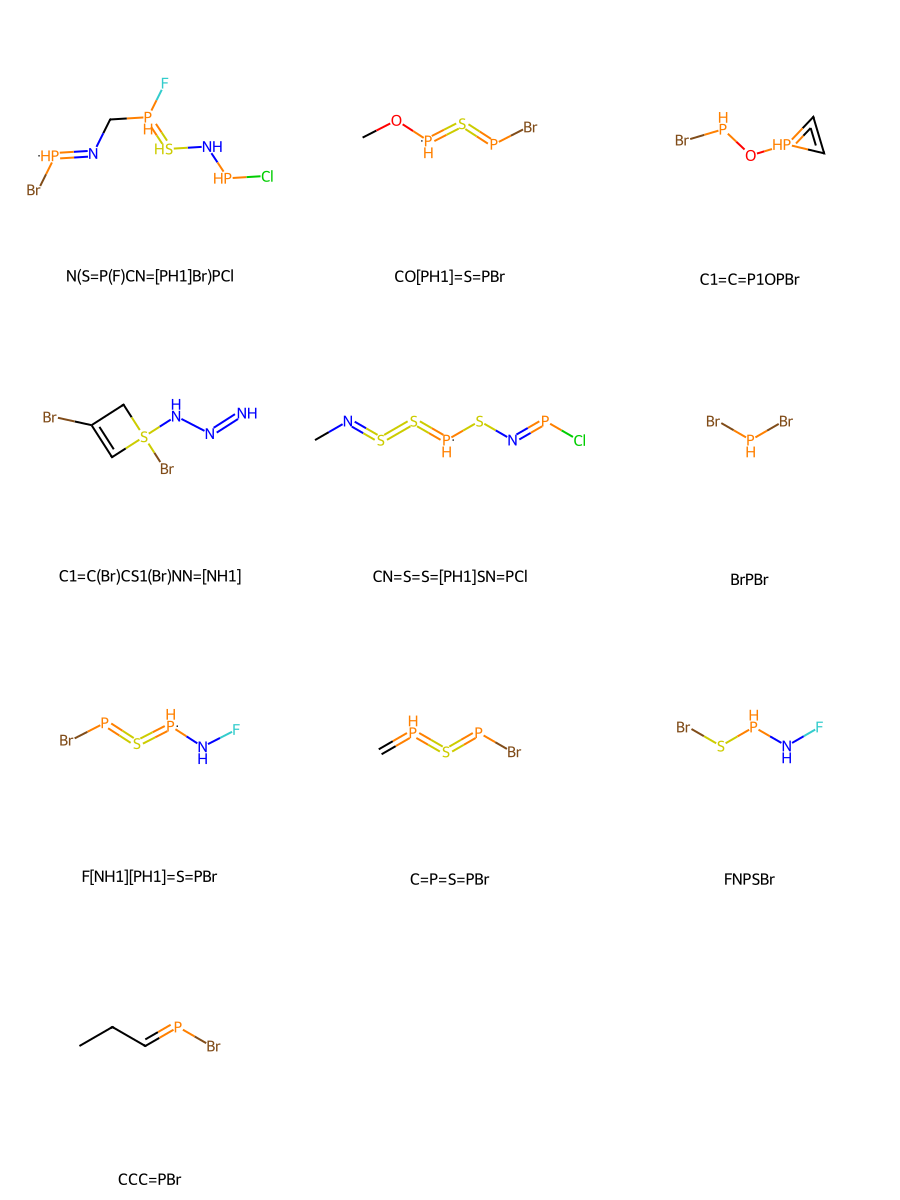

In [76]:
from rdkit.Chem import Draw
from IPython.display import display

# 1. Generate the Molecules
mols = [Chem.MolFromSmiles(s) for s in top_10_df['SMILES']]

# 2. Generate the Grid Image
# CRITICAL FIX: Add 'returnPNG=False' to get a manipulatable PIL object
img = Draw.MolsToGridImage(
    mols, 
    molsPerRow=3, 
    subImgSize=(300, 300), 
    legends=[top_10_df.iloc[i]['SMILES'] for i in range(len(mols))],
    returnPNG=False 
)

# 3. Save the image to a file
img.save(f"../generation/best_molecules_{N_MOLECS}_{fecha}.png")


# 4. Display it in the notebook
display(img)